In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa

In [3]:
sns.set_style('white')

In [4]:
fs = 44100
# 容量の関係上wavではなくmp3で実施します
snare_data, sr = librosa.load('./data/snare.mp3', sr=fs)

### スネア音を基にしたRMW(実信号ウェーブレット)の構築
---

構築においては  
https://ci.nii.ac.jp/naid/130004236409  
に倣い、以下の手順を行う  

1. 実信号から特徴的な部分を切り出す
2. 窓関数をかけて実数RMW $\psi_{R}(t)$ を得る
3. $\left[ \int^{\infty}_{-\infty}\psi _{R}(t)^2dt \right]^{1/2}  = 1$ となるように正規化する
4. $\psi_{R}(t)$ をフーリエ変換し周波数スペクトル $\hat{\psi}_{R}(t)$ を得る
5. ヒルベルト変換を行う
6. 逆フーリエ変換を行って複素数CRMW $\psi(t) = \psi_{R}(t) + i\psi_{I}(t)$ を得る



#### スネア音取得

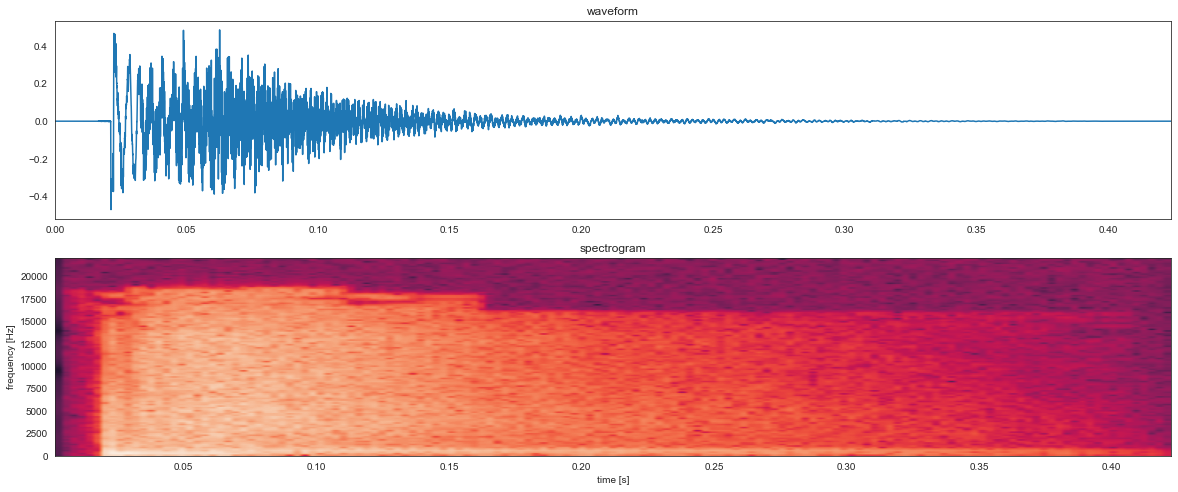

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs = axs.ravel()
xs = np.arange(0, len(snare_data)) / fs
axs[0].plot(xs, snare_data)
axs[0].set_title('waveform')
axs[0].set_xlim(0, len(snare_data)/fs)
axs[1].specgram(snare_data, Fs=fs)
axs[1].set_title('spectrogram')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('frequency [Hz]')
fig.show()

ipd.Audio(snare_data, rate=fs)

#### スネア音の特徴的な部分のみをトリミングする

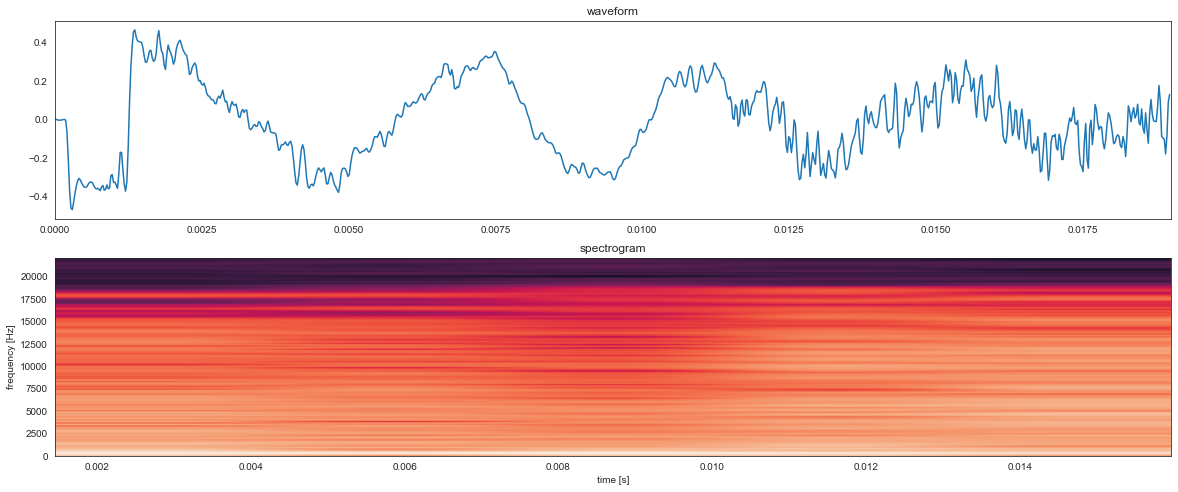

In [6]:
start = int(0.021*fs)
end = int(0.04*fs)
cut_snare_data = snare_data[start:end]

fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs = axs.ravel()
xs = np.arange(0, len(cut_snare_data)) / fs
axs[0].plot(xs, cut_snare_data)
axs[0].set_title('waveform')
axs[0].set_xlim(0, len(cut_snare_data)/fs)
axs[1].specgram(cut_snare_data, Fs=fs)
axs[1].set_title('spectrogram')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('frequency [Hz]')
fig.show()

ipd.Audio(cut_snare_data, rate=fs)

#### 窓関数をかける

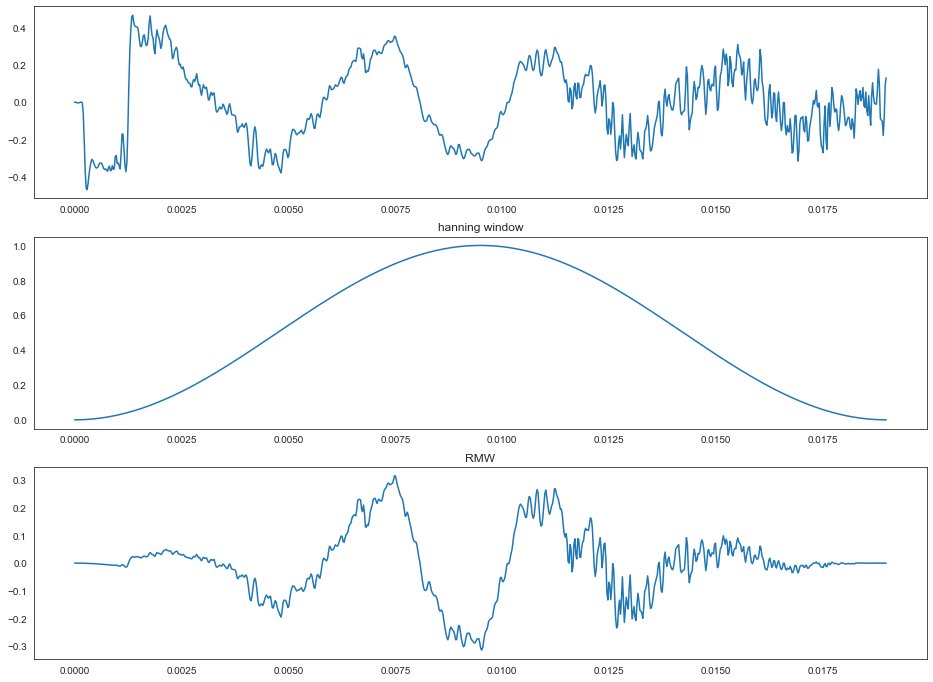

In [7]:
han_win = np.hanning(len(cut_snare_data))
psi_r_t = cut_snare_data*han_win

fig, axs = plt.subplots(3, 1, figsize=(16, 12))
axs = axs.ravel()
xs = np.arange(0, len(psi_r_t)) / fs
axs[0].plot(xs, cut_snare_data)
axs[1].set_title('cut snare')
axs[1].plot(xs, han_win)
axs[1].set_title('hanning window')
axs[2].plot(xs, psi_r_t)
axs[2].set_title('RMW')
fig.show()

ipd.Audio(psi_r_t, rate=fs)

#### 正規化する

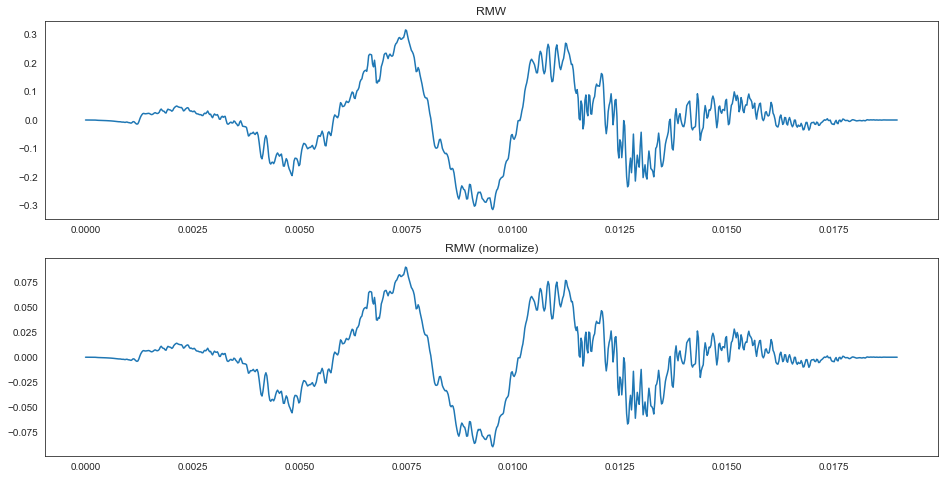

In [8]:
psi_r_t_norm = psi_r_t * (1/np.sqrt(np.sum(psi_r_t**2)))
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
axs = axs.ravel()
xs = np.arange(0, len(psi_r_t)) / fs
axs[0].plot(xs, psi_r_t)
axs[0].set_title('RMW')
axs[1].plot(xs, psi_r_t_norm)
axs[1].set_title('RMW (normalize)')
fig.show()

ipd.Audio(psi_r_t_norm, rate=fs)

#### フーリエ変換　→　ヒルベルト変換　→　逆フーリエ変換

$$
ヒルベルト変換  \\
Z(f) =
    \begin{cases}
        \begin{align}
            2X(f) \quad f &> 0 \\
            X(f) \quad f &= 0 \\ 
            0    \quad    f &< 0 \\   
        \end{align}
    \end{cases}
$$

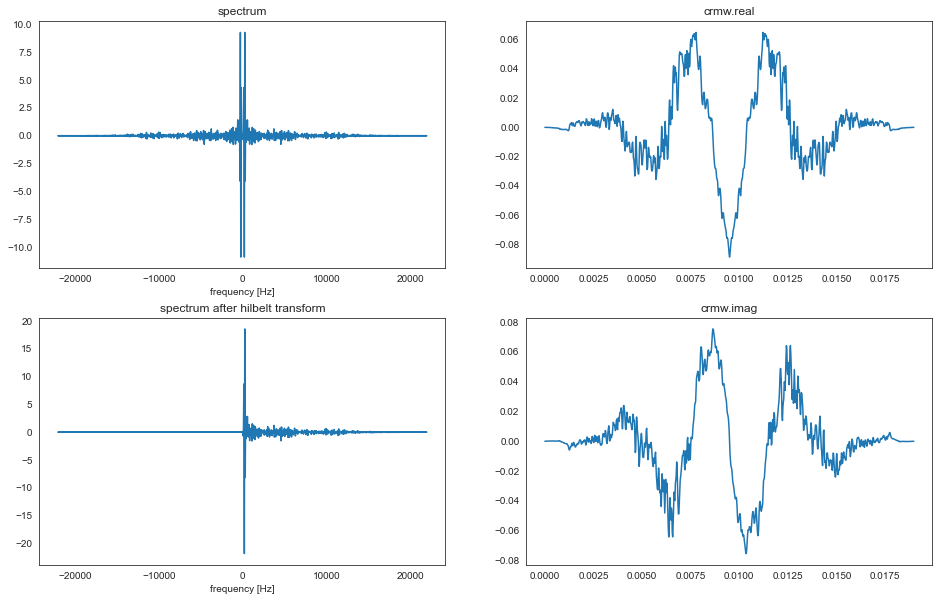

In [9]:
psi_r_f = np.fft.fft(psi_r_t_norm)
N = len(psi_r_t_norm)
freq = np.fft.fftfreq(N, d=1/fs)

cond1_i = np.where(freq > 0)
cond2_i = np.where(freq == 0)
cond3_i = np.where(freq < 0)
psi_r_f_ = np.zeros(len(psi_r_f))
psi_r_f_[cond1_i] = 2*psi_r_f[cond1_i]
psi_r_f_[cond2_i] = psi_r_f[cond2_i]
psi_r_f_[cond3_i] = 0

crmw = np.fft.ifft(psi_r_f_)

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
xs = np.arange(0, len(crmw)) / fs
axs[0, 0].plot(freq, psi_r_f)
axs[0, 0].set_title('spectrum')
axs[0, 0].set_xlabel('frequency [Hz]')
axs[1, 0].plot(freq, psi_r_f_)
axs[1, 0].set_title('spectrum after hilbelt transform')
axs[1, 0].set_xlabel('frequency [Hz]')
axs[0, 1].plot(xs, crmw.real)
axs[0, 1].set_title('crmw.real')
axs[1, 1].plot(xs, crmw.imag)
axs[1, 1].set_title('crmw.imag')
fig.show()

In [10]:
# 自分のバンドの音源で試してみます
# 容量の関係上wavではなくmp3で実施します
target_file = './data/飴玉スライダー.mp3'
data, sr = librosa.load(target_file, sr=44100, offset=0, duration=20)

#### テスト1 静かめな箇所

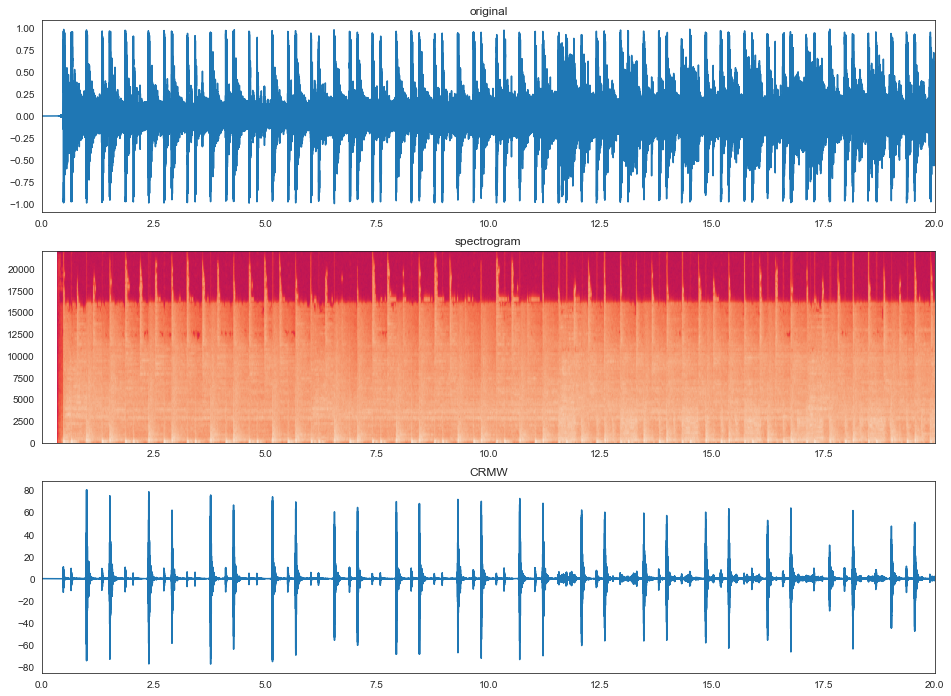

In [11]:
data_crmw = np.convolve(data, crmw, mode='same')
xs = np.arange(0, len(data_crmw)) / fs

fig, axs = plt.subplots(3, 1, figsize=(16, 12))
axs = axs.ravel()
axs[0].plot(xs, data)
axs[0].set_title('original')
axs[0].set_xlim(0, len(data)/fs)
axs[1].specgram(data, Fs=fs)
axs[1].set_title('spectrogram')
axs[2].plot(xs, data_crmw**2)
axs[2].set_title('CRMW')
axs[2].set_xlim(0, len(data)/fs)
fig.show()

ipd.Audio(data, rate=fs)

#### テスト2 サビの賑やか目な箇所

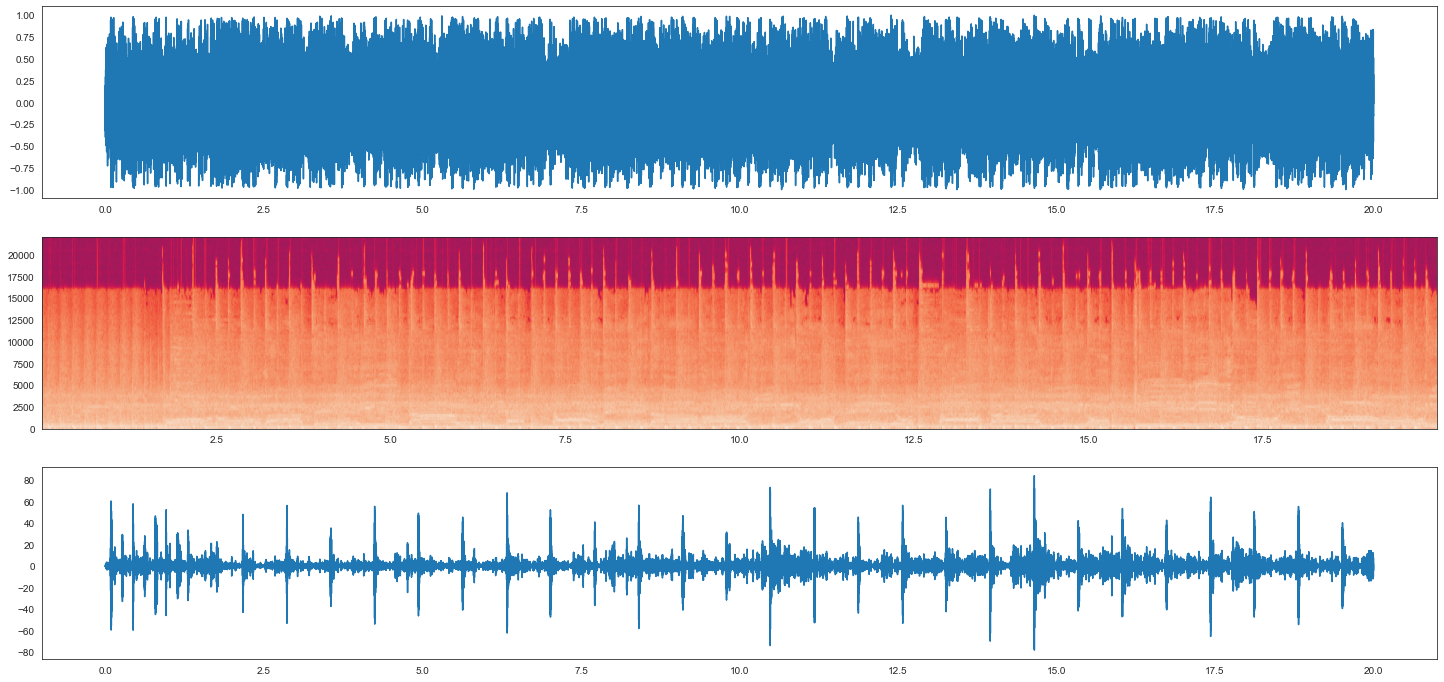

In [12]:
data, sr = librosa.load(target_file, sr=44100, offset=265, duration=20)
data_crmw = np.convolve(data, crmw, mode='same')
widths = np.arange(1, 7)

xs = np.arange(0, len(data))/fs

fig, axs = plt.subplots(3, 1, figsize=(25, 12))
axs = axs.ravel()
axs[0].plot(xs, data)
axs[1].specgram(data, Fs=fs)
axs[2].plot(xs, data_crmw**2)
fig.show()

ipd.Audio(data, rate=fs)

良い感じ！

---
※課題
- 連打を検出できない
- スネアのチューニングが異なる音源に対して無力